In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.mlemodel import MLEModel
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

In [21]:
# Загрузка данных
data = pd.read_excel("./data/Infl_unempl.xlsx", parse_dates=["Date"])
data = data.dropna()
data = data.sort_values("Date").reset_index(drop=True)
data.set_index("Date", inplace=True)
print(data)

            Inflation  Unempoyment
Date                              
2016-01-01       7.09          7.0
2017-01-01       3.70          6.6
2018-01-01       2.88          6.1
2019-01-01       4.48          6.5
2020-01-01       3.38          7.8
2021-01-01       6.68          6.4
2022-01-01      13.75          5.2
2023-01-01       5.95          4.2
2024-01-01       8.44          3.5


In [22]:
## Генерация синтетических данных

np.random.seed(42)
n = data.shape[0]  # количество временных точек

# Генерируем NAIRU как случайное блуждание
NAIRU = np.zeros(n)
for t in range(1, n):
    NAIRU[t] = NAIRU[t - 1] + np.random.normal(0, 0.2)

# Генерируем уровень безработицы
unemployment = data["Unempoyment"]

# Генерируем инфляцию с учетом ожиданий и разрыва безработицы

inflation = data["Inflation"]

# Делаем датафрейм
df = pd.DataFrame({
    'inflation': inflation,
    'unemployment': unemployment,
    'NAIRU_true': NAIRU
})

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                    9
Model:             PhillipsCurveWithExpectations   Log Likelihood                 -34.258
Date:                           Wed, 28 May 2025   AIC                             72.516
Time:                                   23:01:13   BIC                             72.910
Sample:                                        0   HQIC                            71.665
                                             - 9                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
beta           0.8452      1.423      0.594      0.553      -1.945       3.635
alpha1        38.7036      9.553      4.052

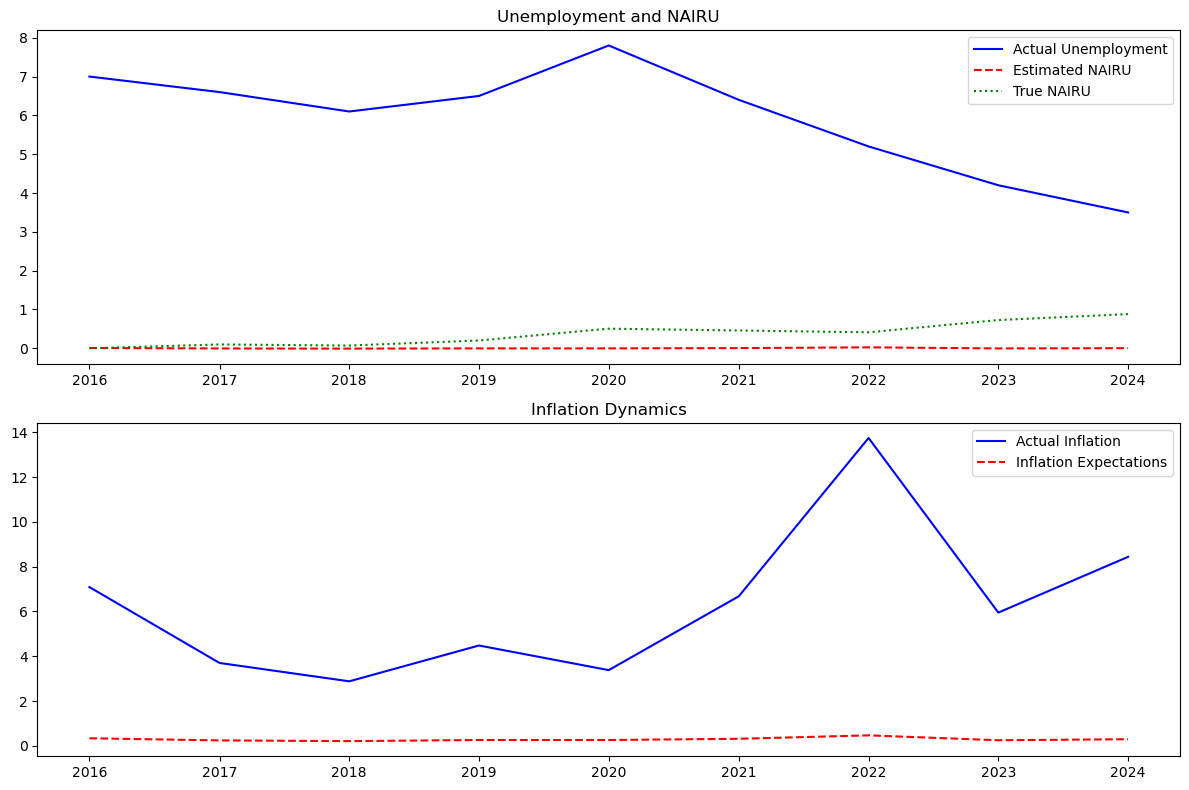

In [23]:
class PhillipsCurveWithExpectations(MLEModel):
    def __init__(self, endog, exog):
        super().__init__(endog, exog=exog, k_states=2, k_posdef=2)
        
        # Фиксируем гиперпараметры для стабильности
        self['transition'] = np.eye(2)
        self['selection'] = np.eye(2)
        self['state_cov'] = np.diag([0.05, 0.01])  # уменьшенные дисперсии
        
        # Инициализация переменных
        self['obs_intercept'] = np.zeros((1, self.nobs))
        self['design'] = np.zeros((1, 2))
        self['obs_cov'] = [[0.1]]  # уменьшенная ошибка измерения
        
        self._param_names = ['beta', 'alpha1']
        self.ssm.initialize_approximate_diffuse()

    @property
    def start_params(self):
        return np.array([0.3, 0.7])  # более реалистичные значения

    def update(self, params, transformed=True, **kwargs):
        params = super().update(params, transformed, **kwargs)
        beta, alpha1 = params
        
        # Важное исправление: учитываем безработицу через obs_intercept
        self['design', 0, 0] = 1.0  # коэффициент для NAIRU
        self['design', 0, 1] = alpha1
        
        # Рассчитываем вклад безработицы (разрыв)
        unemployment_gap = -beta * self.exog[:, 0]
        self['obs_intercept'] = unemployment_gap.reshape(1, -1)
        
        return params

# Подготовка данных
endog = df['inflation'].values
exog = df['unemployment'].values.reshape(-1, 1)  # безработица как exog

# Создание и обучение модели
mod = PhillipsCurveWithExpectations(endog, exog=exog)
res = mod.fit(maxiter=50, method='nm')  # метод Нелдера-Мида стабильнее

print(res.summary())

# Получение оценок состояний
smoothed_states = res.smoothed_state
df_results = df.copy()
df_results['NAIRU_estimated'] = smoothed_states[0]
df_results['Inflation_Expectations'] = smoothed_states[1]
df_results['Gap'] = df_results['unemployment'] - df_results['NAIRU_estimated']

# Визуализация результатов
plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.plot(df_results.index, df_results['unemployment'], 'b-', label='Actual Unemployment')
plt.plot(df_results.index, df_results['NAIRU_estimated'], 'r--', label='Estimated NAIRU')
plt.plot(df_results.index, df_results['NAIRU_true'], 'g:', label='True NAIRU')
plt.title('Unemployment and NAIRU')
plt.legend()

plt.subplot(212)
plt.plot(df_results.index, df_results['inflation'], 'b-', label='Actual Inflation')
plt.plot(df_results.index, df_results['Inflation_Expectations'], 'r--', label='Inflation Expectations')
plt.title('Inflation Dynamics')
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
print(df_results)

            inflation  unemployment  NAIRU_true  NAIRU_estimated  \
Date                                                               
2016-01-01       7.09           7.0    0.000000         0.008660   
2017-01-01       3.70           6.6    0.099343        -0.003606   
2018-01-01       2.88           6.1    0.071690        -0.007725   
2019-01-01       4.48           6.5    0.201228        -0.001388   
2020-01-01       3.38           7.8    0.505834        -0.001304   
2021-01-01       6.68           6.4    0.459003         0.005775   
2022-01-01      13.75           5.2    0.412176         0.025518   
2023-01-01       5.95           4.2    0.728018        -0.002695   
2024-01-01       8.44           3.5    0.881505         0.003352   

            Inflation_Expectations       Gap  
Date                                          
2016-01-01                0.335191  6.991340  
2017-01-01                0.240239  6.603606  
2018-01-01                0.208359  6.107725  
2019-01-01      

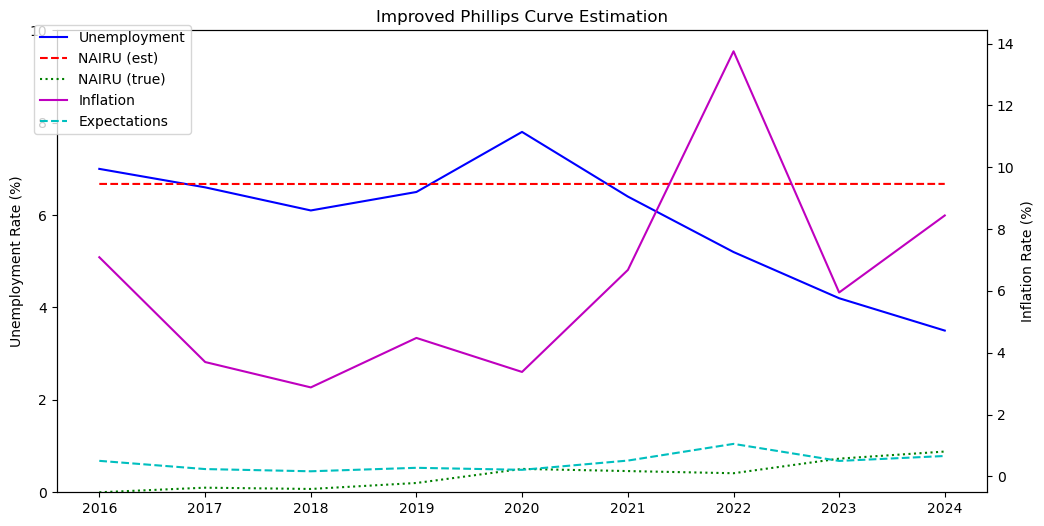

In [25]:
class ImprovedPhillipsCurve(MLEModel):
    def __init__(self, endog, exog):
        super().__init__(endog, exog=exog, k_states=2, k_posdef=2)
        
        # Фиксированные гиперпараметры для стабильности
        self['transition'] = np.eye(2)
        self['selection'] = np.eye(2)
        self['state_cov'] = np.diag([0.01, 0.1])  # уменьшенная дисперсия NAIRU
        
        # Инициализация переменных с правильной размерностью
        self['obs_intercept'] = np.zeros((1, len(endog)))  # (1, nobs)
        self['design'] = np.zeros((1, 2, len(endog)))     # (k_endog, k_states, nobs)
        self['obs_cov'] = [[1.0]]  # увеличенная ошибка измерения
        
        # Параметры для оценки
        self._param_names = ['beta', 'alpha1', 'delta']
        self.ssm.initialize_approximate_diffuse()
    
    
    # Тут можно напихать распределений
    
    '''
    import pymc as pm

    with pm.Model():
        # Априорные распределения
        beta = pm.Normal('beta', mu=0.5, sigma=0.2)
        alpha1 = pm.Beta('alpha1', alpha=2, beta=2)
        delta = pm.Beta('delta', alpha=3, beta=1)
    
    # Реализация модели пространства состояний
    '''
    
    
    @property
    def start_params(self):
        return np.array([0.5, 0.8, 0.5])  # beta, alpha1, delta

    def update(self, params, transformed=True, **kwargs):
        params = super().update(params, transformed, **kwargs)
        beta, alpha1, delta = params
        
        # Механизм адаптивных ожиданий
        self['design', 0, 0, :] = -beta  # коэффициент для разрыва безработицы
        self['design', 0, 1, :] = alpha1  # коэффициент для ожиданий
        
        # Обновление уравнения перехода для ожиданий
        self['transition', 1, 1] = delta  # коэффициент инерции ожиданий
        
        # Внешний шок (включая обменный курс)
        # Правильная размерность (1, nobs)
        self['obs_intercept'] = (-beta * self.exog[:, 0] * 0.2).reshape(1, -1)
        
        return params

# Подготовка данных
endog = df['inflation'].values
exog = df[['unemployment']].values  # можно добавить обменный курс

# Создание и обучение модели
mod = ImprovedPhillipsCurve(endog, exog=exog)
res = mod.fit(maxiter=100, method='nm', disp=True)

# Получение оценок состояний
smoothed_states = res.smoothed_state
df_results = df.copy()
df_results['NAIRU_estimated'] = smoothed_states[0] + 5.0  # смещение для положительных значений
df_results['Inflation_Expectations'] = smoothed_states[1]
df_results['Gap'] = df_results['unemployment'] - df_results['NAIRU_estimated']

# Визуализация
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# График 1: Безработица и NAIRU
ax1.plot(df_results.index, df_results['unemployment'], 'b-', label='Unemployment')
ax1.plot(df_results.index, df_results['NAIRU_estimated'], 'r--', label='NAIRU (est)')
ax1.plot(df_results.index, df_results['NAIRU_true'], 'g:', label='NAIRU (true)')
ax1.set_ylabel('Unemployment Rate (%)')
ax1.set_ylim(0, 10)

# График 2: Инфляция и ожидания
ax2.plot(df_results.index, df_results['inflation'], 'm-', label='Inflation')
ax2.plot(df_results.index, df_results['Inflation_Expectations'], 'c--', label='Expectations')
ax2.set_ylabel('Inflation Rate (%)')

plt.title('Improved Phillips Curve Estimation')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()

In [26]:
df_results

,inflation,unemployment,NAIRU_true,NAIRU_estimated,Inflation_Expectations,Gap
Date,,,,,,
2016-01-01,7.09,7.0,0.000000,6.674197,0.505134,0.325803
2017-01-01,3.70,6.6,0.099343,6.673205,0.239115,-0.073205
2018-01-01,2.88,6.1,0.071690,6.672939,0.167748,-0.572939
2019-01-01,4.48,6.5,0.201228,6.673357,0.279991,-0.173357
2020-01-01,3.38,7.8,0.505834,6.673115,0.215065,1.126885
2021-01-01,6.68,6.4,0.459003,6.674230,0.513998,-0.274230
2022-01-01,13.75,5.2,0.412176,6.676243,1.053637,-1.476243
2023-01-01,5.95,4.2,0.728018,6.674189,0.502793,-2.474189
2024-01-01,8.44,3.5,0.881505,6.674783,0.662115,-3.174783


In [ ]:
import pandas as pd
import numpy as np

data = {
    'Date': ['2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01',
             '2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01', '2024-01-01'],
    'Inflation': [7.09, 3.70, 2.88, 4.48, 3.38, 6.68, 13.75, 5.95, 8.44],
    'Unempoyment': [7.0, 6.6, 6.1, 6.5, 7.8, 6.4, 5.2, 4.2, 3.5]
}

df = pd.DataFrame(data)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Данные в массивы
inflation = df['Inflation'].values
unemployment = df['Unempoyment'].values

In [ ]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных
data = pd.read_excel("./data/Infl_unempl.xlsx", parse_dates=["Date"])
data = data.dropna().sort_values("Date").set_index("Date")

# Добавим синтетические данные об обменном курсе (пример)
np.random.seed(42)
data['ExchangeRate'] = np.random.normal(0, 0.5, size=len(data))

# Подготовка данных
inflation = data['Inflation'].values
unemployment = data['Unempoyment'].values
exchange_rate = data['ExchangeRate'].values
dates = data.index

with pm.Model() as phillips_model:
    # Априорные распределения для параметров
    alpha = pm.Normal('alpha', mu=0, sigma=2)  # Константа
    beta = pm.Normal('beta', mu=-0.5, sigma=1)  # Чувствительность к разрыву безработицы
    gamma = pm.Normal('gamma', mu=0.3, sigma=0.5)  # Чувствительность к обменному курсу
    delta = pm.Beta('delta', alpha=2, beta=2)  # Коэффициент адаптивных ожиданий
    
    # Процесс для NAIRU (случайное блуждание)
    nairu_sigma = pm.HalfNormal('nairu_sigma', sigma=0.5)
    nairu = pm.GaussianRandomWalk('nairu', mu=0, sigma=nairu_sigma, shape=len(unemployment))
    
    # Процесс для инфляционных ожиданий (адаптивные ожидания)
    expect_sigma = pm.HalfNormal('expect_sigma', sigma=0.5)
    expectations = pm.GaussianRandomWalk('expectations', mu=0, sigma=expect_sigma, shape=len(inflation))
    
    # Разрыв безработицы
    gap = pm.Deterministic('gap', unemployment - nairu)
    
    # Механизм адаптивных ожиданий
    adaptive_expectations = pm.Deterministic(
        'adaptive_expectations', 
        delta * expectations[:-1] + (1 - delta) * inflation[:-1]
    )
    
    # Уравнение кривой Филлипса
    mu = alpha + beta * gap[1:] + gamma * exchange_rate[1:] + adaptive_expectations
    
    # Наблюдаемая инфляция
    sigma = pm.HalfNormal('sigma', sigma=1)
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=inflation[1:])
    
    # Сэмплирование
    trace = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True)
    
    # Апостериорные предсказания
    ppc = pm.sample_posterior_predictive(trace, var_names=['obs', 'nairu', 'expectations', 'gap'])

In [ ]:


    # Вывод
    trace = pm.sample(1000, tune=1000, target_accept=0.95)